#Thermodynamics Notebook

Adding necessary imports

In [4]:
import numpy as np
from math import *
from scipy.optimize import fsolve, root, brentq, newton, bisect
import matplotlib.pyplot as plt

Universal Gas Constant:

In [5]:
R = 8.314 # [kg/(J.K)]

The van der Waals Equation of State is given by
$$
P = \frac{RT}{v - b} - \frac{a}{v^2}
$$

We can write it in a cubic equation form:
$$
v^3 - \left( b + \frac{RT}{P} \right) v^2 + \frac{a}{P}v - \frac{ab}{P} = 0
$$

where we need to find the roots of $v$. Or we could use the compressibility factor $Z = \frac{Pv}{RT}$ and solve the following

$$
Z^3 - \frac{P}{RT} \left( b + \frac{RT}{P} \right) Z^2 + \frac{P}{RT}^2 \frac{a}{P}Z - \frac{ab}{P} \frac{P}{RT}^3 = 0
$$

$$
A = \frac{aP}{(RT)^2}
$$

$$
B = \frac{bP}{RT}
$$

$$
Z^3 - \left( B + 1 \right) Z^2 +  AZ - AB = 0
$$

The fugacity is given by

$$
\ln \phi_i = \ln \frac{f_i}{x_i P} = \frac{1}{RT} \int_{V}^{\infty} \left( \frac{\partial P}{\partial N_i} - \frac{RT}{V}\right) dV - \ln Z
$$

$$
\ln f_i = \ln \left( \frac{y_i}{v - b} \right) + \frac{b_i}{v-b} - \frac{2 \sum_j y_j a_{ij}}{vRT}
$$

Or in terms of $Z$:

$$
\ln \frac{f_i}{y_i P} = \frac{B_i}{Z-B} -\ln \left( Z - B \right) - \frac{2 \sum_j y_j A_{ij}}{Z}
$$

The block of code below represent some auxiliary methods. The `find_correct_root_of_cubic_eos(...)` method calculated the correct cubic root (smallest root for liquid and largest root for vapor).

In [6]:
def cbrt(x):
    ''' 
    This method calculates the cubic root of a negative value.
    
    '''
    if x >= 0.0:                
        return x ** (1.0/3.0)
    else:
        return -(abs(x) ** (1.0/3.0))
    
def find_correct_root_of_cubic_eos(p0, p1, p2, p3, fluid_type):
    coef_a = (3.0 * p2 - (p1 ** 2)) / 3.0        
    coef_b = (2.0 * (p1 ** 3) - 9.0 * p1 * p2 + 27.0 * p3) / 27.0        
    delta = 0.25 * (coef_b ** 2) + (coef_a ** 3) / 27.0     

    if delta > 0.0:
        # 1 real root, 2 imaginary                 
        const_A =  cbrt(-0.5 * coef_b + sqrt(delta)) 
        const_B =  cbrt(-0.5 * coef_b - sqrt(delta))

        correct_root = const_A + const_B - p1 / 3.0 
    else:
        # 3 real roots
        phi = acos(-0.5 * coef_b / sqrt(-(coef_a ** 3) / 27.0))
        root_1 = 2.0 * sqrt(-coef_a / 3.0) * cos(phi / 3.0) - p1 / 3.0
        root_2 = 2.0 * sqrt(-coef_a / 3.0) * cos(phi / 3.0 + 2.0 * np.pi / 3.0) - p1 / 3.0
        root_3 = 2.0 * sqrt(-coef_a / 3.0) * cos(phi / 3.0 + 4.0 * np.pi / 3.0) - p1 / 3.0

        smallest_root = min(min(root_1,root_2), root_3)
        largest_root = max(max(root_1,root_2), root_3)

        if fluid_type is 'liquid':        
            correct_root = smallest_root
        else:
            assert fluid_type is 'vapor', 'Wrong fluid type! ' + fluid_type
            correct_root = largest_root
    
    assert correct_root > 0.0, fluid_type + ' Z-factor < 0.0! Delta is %f, %f' % (delta, correct_root)
    
    return correct_root

def calculate_roots_of_cubic_eos(p0, p1, p2, p3):
    coef_a = (3.0 * p2 - (p1 ** 2)) / 3.0        
    coef_b = (2.0 * (p1 ** 3) - 9.0 * p1 * p2 + 27.0 * p3) / 27.0        
    delta = 0.25 * (coef_b ** 2) + (coef_a ** 3) / 27.0     

    roots = []
    if delta > 0.0:
        # 1 real root, 2 imaginary                 
        const_A =  cbrt(-0.5 * coef_b + sqrt(delta)) 
        const_B =  cbrt(-0.5 * coef_b - sqrt(delta))
        
        single_root = const_A + const_B - p1 / 3.0
        
        assert single_root > 0.0, 'Z-factor < 0.0! Delta is %f, %f' % (delta, single_root)
        
        roots.append(single_root) 
    else:
        # 3 real roots
        phi = acos(-0.5 * coef_b / sqrt(-(coef_a ** 3) / 27.0))
        root_1 = 2.0 * sqrt(-coef_a / 3.0) * cos(phi / 3.0) - p1 / 3.0
        root_2 = 2.0 * sqrt(-coef_a / 3.0) * cos(phi / 3.0 + 2.0 * np.pi / 3.0) - p1 / 3.0
        root_3 = 2.0 * sqrt(-coef_a / 3.0) * cos(phi / 3.0 + 4.0 * np.pi / 3.0) - p1 / 3.0

        smallest_root = min(min(root_1,root_2), root_3)
        assert smallest_root > 0.0, 'Z-factor < 0.0! Delta is %f, %f' % (delta, smallest_root)
        
        largest_root = max(max(root_1,root_2), root_3)
        assert largest_root > 0.0, 'Z-factor < 0.0! Delta is %f, %f' % (delta, largest_root)
        
        roots.append(smallest_root)
        roots.append(largest_root)
    
    return roots

The base `EquationOfState` class will be used for all cubic Equations of State.

In [7]:
class EquationOfState():
    def __init__(
        self,
        critical_pressure, 
        critical_temperature,
        acentric_factor,
        omega_a,
        omega_b,
        binary_interaction
    ):
        self.critical_pressure = critical_pressure
        self.critical_temperature = critical_temperature
        self.acentric_factor = acentric_factor
        self.omega_a = omega_a
        self.omega_b = omega_b
        self.binary_interaction = binary_interaction
    
    def set_molar_fractions(self, molar_fractions):
        self.molar_fractions = molar_fractions
    
    def alpha_function(self, temperature, critical_temperature, acentric_factor):
        return 1.0
    
    def calculate_eos_coefficients(self, pressure, temperature):
        alpha = self.alpha_function(temperature, self.critical_temperature, self.acentric_factor)
        
        a = (self.omega_a * alpha * (R * self.critical_temperature) ** 2) / self.critical_pressure
        b = (self.omega_b * R * self.critical_temperature) / self.critical_pressure
        a *= pressure / (R * temperature) ** 2
        b *= pressure / (R * temperature)

        return a, b

    def update_eos_coefficients(self, pressure, temperature):
        x = self.molar_fractions
        
        BI = self.binary_interaction

        self.a, self.b = self.calculate_eos_coefficients(pressure, temperature)
        
        AIJ = (1.0 - BI) * np.sqrt(np.einsum('i,j', self.a, self.a))

        # This variables will be used in the fugacity expression
        self.numerator_coef = np.einsum('ij,j', AIJ, x)
        
        self.mixture_a = np.dot(np.dot(x, AIJ), x)
        self.mixture_b = np.sum(x * self.b)
        
    def calculate_normalized_gibbs_energy(fugacities):        
        normalized_gibbs_energy = 0.0
        
        for x, fugacity in izip(self.molar_fractions, fugacities):
            normalized_gibbs_energy += x[i]*log(fugacity)
            
        return normalized_gibbs_energy
    
    def calculate_fugacities_with_minimum_gibbs_energy(self, pressure, temperature):
        # TODO: Work in progress, calculate fugacities by 
        # calculating all roots and if it has two possible roots
        # calculate both minimim gibbs energy and choose the 
        # group of fugacities with minimum gibbs energy
               
        self.update_eos_coefficients(pressure, temperature)
        #for Z in z_factors: 
        
            

In [8]:
class VanDerWaalsEos(EquationOfState):           
    def calculate_eos_roots(self, fluid_type):
        A_mix = self.mixture_a
        B_mix = self.mixture_b
        
        p0 = 1.0
        p1 = - (B_mix + 1.0)
        p2 = A_mix
        p3 = - A_mix * B_mix   
        
        return find_correct_root_of_cubic_eos(p0, p1, p2, p3, fluid_type)    
    
    def calculate_fugacities(
        self,
        pressure,
        temperature,
        z_factor        
    ):
        P = pressure
        T = temperature
        Z = z_factor
        x = self.molar_fractions        
        a = self.a
        a_mix = self.mixture_a
        b = self.b
        b_mix = self.mixture_b        
        sum_x_j_A_ij = self.numerator_coef
        
        ln_f = b / (Z - b_mix) - np.log(Z - b_mix) - 2.0 * sum_x_j_A_ij / Z
        
        return (x * P) * np.exp(ln_f) # [Pa]
        

In [9]:
class PengRobinsonEos(EquationOfState):     
    def alpha_function(self, temperature, critical_temperature, acentric_factor):
        m = np.where(
            acentric_factor < 0.49, 
            0.37464 + 1.54226 * acentric_factor - 0.26992 * (acentric_factor ** 2), 
            0.379642 + 1.48503 * acentric_factor - 0.164423 * (acentric_factor ** 2) + 0.016667 * (acentric_factor ** 3)
        )
        return (1.0 + m * (1.0 - np.sqrt(temperature / critical_temperature))) ** 2
    
    def calculate_eos_roots(self, fluid_type):
        A_mix = self.mixture_a
        B_mix = self.mixture_b        
        
        p0 = 1.0
        p1 = - (1.0 - B_mix)
        p2 = A_mix - 3.0 * (B_mix ** 2) - 2.0 * B_mix
        p3 = -(A_mix * B_mix - B_mix ** 2 - B_mix ** 3)     

        return find_correct_root_of_cubic_eos(p0, p1, p2, p3, fluid_type)       
        
    def calculate_fugacities(
        self,
        pressure,
        temperature,
        z_factor
    ):
        P = pressure
        T = temperature
        Z = z_factor
        x = self.molar_fractions        
        a = self.a
        a_mix = self.mixture_a
        b = self.b
        b_mix = self.mixture_b        
        sum_x_j_A_ij = self.numerator_coef
        SQRT_2 = sqrt(2.0)
        
        ln_f = (b / b_mix)*(Z - 1.0) - np.log( Z - b_mix ) \
             + (a_mix / (2.0 * SQRT_2 * b_mix)) \
             * ( (b / b_mix) - 2.0 * sum_x_j_A_ij / a_mix ) \
             * np.log( (Z + (1.0 + SQRT_2)*b_mix)/(Z + (1.0 - SQRT_2)*b_mix) )
    
        return (x * P) * np.exp(ln_f) # [Pa]
        

In [10]:
class SoaveRedlichKwongEos(EquationOfState):      
    def alpha_function(self, temperature, critical_temperature, acentric_factor):
        m = 0.480 + 1.574 * acentric_factor - 0.176 * (acentric_factor ** 2)
        return (1.0 + m * (1.0 - np.sqrt(temperature / critical_temperature))) ** 2
        
    def calculate_eos_roots(self, fluid_type):
        A_mix = self.mixture_a
        B_mix = self.mixture_b        
        
        p0 = 1.0
        p1 = -1.0
        p2 = A_mix - B_mix - (B_mix ** 2) 
        p3 = -(A_mix * B_mix)     

        return find_correct_root_of_cubic_eos(p0, p1, p2, p3, fluid_type)       
        
    def calculate_fugacities(
        self,
        pressure,
        temperature,
        z_factor
    ):
        P = pressure
        T = temperature
        Z = z_factor
        x = self.molar_fractions        
        a = self.a
        a_mix = self.mixture_a
        b = self.b
        b_mix = self.mixture_b        
        sum_x_j_A_ij = self.numerator_coef
        SQRT_2 = sqrt(2.0)
        
        ln_f = (b / b_mix)*(Z - 1.0) - np.log( Z - b_mix ) \
             + (a_mix / b_mix) \
             * ( (b / b_mix) - 2.0 * sum_x_j_A_ij / a_mix ) \
             * np.log(1.0 + (b_mix / Z))
    
        return (x * P) * np.exp(ln_f) # [Pa]
        

In [11]:
def func_rachford_rice(x, global_molar_fractions, K_values):
    z = global_molar_fractions
    c = 1.0 / (K_values - 1.0)
    return np.sum(z / (c + x))
    
def deriv_rachford_rice(x, global_molar_fractions, K_values):
    z = global_molar_fractions
    c = 1.0 / (K_values - 1.0)
    return - np.sum(z / ((c + x) ** 2))
    
def calculate_rachford_rice(global_molar_fractions, K_values):
    min_K = np.min(K_values)
    max_K = np.max(K_values)

    min_val = 0.999 / (1.0 - max_K)
    max_val = 0.999 / (1.0 - min_K) 
  
    F_V = brentq(func_rachford_rice, min_val, max_val, args=(global_molar_fractions, K_values))
    #F_V = newton(func=func_rachford_rice, x0=0.5, fprime=deriv_rachford_rice, args=(global_molar_fractions, K_values))
    #F_V = bisect(func_rachford_rice, min_val, max_val, args=(global_molar_fractions, K_values))

    return F_V

In [12]:
def flash_residual_function(x, temperature, pressure, eos, global_molar_fractions):
    T = temperature
    P = pressure
    z = global_molar_fractions
    
    size = x.shape[0]
    
    K = x[0:size-1] # K-values
    K_minus_one = (K - 1.0)
    
    F_V = x[size-1]

    if F_V < 0.0:
        F_V = 0.0
    if F_V > 1.0:
        F_V = 1.0
        
    x_L = z / (F_V * K_minus_one + 1.0)
    x_V = K * x_L
    
    # Vapor
    eos.set_molar_fractions(x_V)
    eos.update_eos_coefficients(P, T)
    z_factor = eos.calculate_eos_roots('vapor')    
    f_V = eos.calculate_fugacities(P, T, z_factor)
    
    # Liquid
    eos.set_molar_fractions(x_L)
    eos.update_eos_coefficients(P, T)
    z_factor = eos.calculate_eos_roots('liquid')        
    f_L = eos.calculate_fugacities(P, T, z_factor)
    
    residual_fugacity = f_L - f_V 
    residual_mass = np.sum(z * K_minus_one / (1.0 + F_V * K_minus_one))
    residual = np.append(residual_fugacity, residual_mass)

    return residual

In [13]:
def stability_test_residual_function(x, temperature, pressure, eos, global_molar_fractions, test_type):
    T = temperature
    P = pressure
    z = global_molar_fractions    
    u = x # Getting unknowns

    eos.set_molar_fractions(z)
    eos.update_eos_coefficients(P, T)
    z_factor = eos.calculate_eos_roots(test_type)    
    f_ref = eos.calculate_fugacities(P, T, z_factor)
    
    if test_type is 'vapor':
        other_type = 'liquid'
        K_values = u / z
        x_u = z * K_values
        
    else:
        assert test_type is 'liquid', 'Non existing test_type! ' + test_type
        other_type = 'vapor'
        K_values = z / u
        x_u = z / K_values
    
    x_u_normalized = x_u / np.sum(x_u)
    
    eos.set_molar_fractions(x_u_normalized)
    eos.update_eos_coefficients(P, T)
    z_factor = eos.calculate_eos_roots(other_type)        
    f_u = eos.calculate_fugacities(P, T, z_factor)
    
    residual = f_ref - f_u * np.sum(x_u)

    return residual

In [14]:
def calculate_K_values_wilson(
    pressure,
    temperature,
    critical_pressure,
    critical_temperature,
    acentric_factor
):
    P = pressure
    T = temperature
    P_c = critical_pressure
    T_c = critical_temperature
    omega = acentric_factor
    
    return (P_c / P) * np.exp(5.37 * (1.0 + omega) * (1.0 - (T_c / T)))

# Successive Substitution Flash Routine

In [16]:
def ss_flash(
    eos,
    pressure, 
    temperature, 
    global_molar_fractions, 
    initial_K_values, 
    max_iter = 50,
    tolerance = 1.0e-3,
    print_statistics=False
):
    P = pressure
    T = temperature
    z = global_molar_fractions
    K = np.copy(initial_K_values)

    # Initialize error with some value
    error = 100.0

    counter = 0
    while error > tolerance and counter < max_iter:
        K_minus_one = K - 1.0

        F_V = calculate_rachford_rice(global_molar_fractions, K)
        x_L = z / (F_V * K_minus_one + 1.0)
        x_V = K * x_L

        # Vapor
        eos.set_molar_fractions(x_V)
        eos.update_eos_coefficients(P, T)
        z_factor = eos.calculate_eos_roots('vapor')    
        f_V = eos.calculate_fugacities(P, T, z_factor)

        # Liquid
        eos.set_molar_fractions(x_L)
        eos.update_eos_coefficients(P, T)
        z_factor = eos.calculate_eos_roots('liquid')
        f_L = eos.calculate_fugacities(P, T, z_factor)

        f_ratio = f_L / f_V
        K *= f_ratio

        error = np.linalg.norm(f_ratio - 1)
        counter += 1
    
    if print_statistics:
        print ('SS Flash: %d iterations, error is %g.' %(counter, error))
        
    return K, F_V, f_L

# Stability Test Routine

In [17]:
def ss_stability_test(
    eos,
    pressure, 
    temperature, 
    global_molar_fractions, 
    test_type,
    initial_K_values,
    max_iter = 100,
    tolerance = 1.0e-5
):
    P = pressure
    T = temperature
    z = global_molar_fractions
    K = np.copy(initial_K_values)

    error = 100.0

    eos.set_molar_fractions(z)
    eos.update_eos_coefficients(P, T)
    z_factor = eos.calculate_eos_roots(test_type)    
    f_ref = eos.calculate_fugacities(P, T, z_factor)
        
    counter = 0
    while error > tolerance and counter < max_iter:
        if test_type is 'vapor':
            other_type = 'liquid'
            x_u = z * K
        else:
            assert test_type is 'liquid', 'Non existing test_type! ' + test_type
            other_type = 'vapor'
            x_u = z / K        
        
        sum_x_u = np.sum(x_u)
        x_u_normalized = x_u / sum_x_u
        
        eos.set_molar_fractions(x_u_normalized)
        eos.update_eos_coefficients(P, T)
        z_factor = eos.calculate_eos_roots(other_type)        
        f_u = eos.calculate_fugacities(P, T, z_factor)        
        
        if test_type is 'vapor':            
            correction = f_ref / (f_u * sum_x_u)
        else:
            assert test_type is 'liquid', 'Non existing test_type! ' + test_type
            correction = (f_u * sum_x_u) / f_ref
            
        K *= correction    
        error = np.linalg.norm(correction - 1.0)
        counter += 1

    return sum_x_u, K

def calculate_stability_test(
    eos,
    pressure, 
    temperature, 
    global_molar_fractions,
    initial_K_values
):    
    sum_vapor, K_values_vapor = ss_stability_test(
        eos,
        pressure, 
        temperature, 
        global_molar_fractions,
        'vapor',
        initial_K_values
    )

    sum_liquid, K_values_liquid = ss_stability_test(
        eos,
        pressure, 
        temperature, 
        global_molar_fractions,
        'liquid',
        initial_K_values
    )
    
    sum_ln_K_vapor = np.linalg.norm(np.log(K_values_vapor)) ** 2
    sum_ln_K_liquid = np.linalg.norm(np.log(K_values_liquid)) ** 2
    sum_tol = 1.0e-8

    if sum_ln_K_vapor < 1.0e-4 and sum_ln_K_liquid < 1.0e-4:
        is_stable = True
    elif (sum_vapor-1.0) <= sum_tol and sum_ln_K_liquid < 1.0e-4:
        is_stable = True
    elif (sum_liquid-1.0) <= sum_tol and sum_ln_K_vapor < 1.0e-4:
        is_stable = True
    elif (sum_vapor-1.0) <= sum_tol and (sum_liquid-1.0) <= sum_tol:
        is_stable = True
    elif (sum_vapor-1.0) > sum_tol and sum_ln_K_liquid < 1.0e-4:
        is_stable = False
    elif (sum_liquid-1.0) > sum_tol and sum_ln_K_vapor < 1.0e-4:
        is_stable = False
    elif (sum_vapor-1.0) > sum_tol and (sum_liquid-1.0) > sum_tol:
        is_stable = False
    elif (sum_vapor-1.0) > sum_tol and (sum_liquid-1.0) <= sum_tol:
        is_stable = False
    elif (sum_vapor-1.0) <= sum_tol and (sum_liquid-1.0) > sum_tol:
        is_stable = False
    else:
        assert False, 'ERROR: No stability condition found...'

    if is_stable:
        K_values_estimates = K_values_vapor * K_values_liquid
    else:
        K_values_estimates = np.copy(initial_K_values)

    return is_stable, K_values_estimates

# Input Data

In [18]:
def input_properties_case_7_psudocomponents():
    '''
    7 pseudo-components
    
    '''
    
    temperature = 366.5
    pressure = 150.0 * 1.0e5

    critical_pressure = 101325.0 * np.array([45.45, 51.29, 39.89, 31.95, 27.91, 17.71, 12.52]) # [atm]
    critical_temperature = np.array([189.2, 305.4, 395.8, 485.1, 592.0, 697.1, 804.4]) # [K]
    acentric_factor = np.array([0.00891, 0.11352, 0.17113, 0.26910, 0.34196, 0.51730, 0.72755]) # [-]
    molar_mass = 0.001 * np.array([16.38, 31.77, 50.64, 77.78, 118.44, 193.95, 295.30]) # [g/mol]
    omega_a = np.array([0.344772, 0.521974, 0.514972, 0.419169, 0.485943, 0.570583, 0.457236]) # [-]
    omega_b = np.array([0.063282, 0.099825, 0.107479, 0.093455, 0.07486, 0.101206, 0.077796]) # [-]

    binary_interaction = np.array(
    [[ 0.000000,  0.000622, -0.002471,  0.011418, -0.028367, -0.100000, 0.206868],
     [ 0.000622,  0.000000, -0.001540,  0.010046,  0.010046,  0.010046, 0.010046],
     [-0.002471, -0.001540,  0.000000,  0.002246,  0.002246,  0.002246, 0.002246],
     [ 0.011418,  0.010046,  0.002246,  0.000000,  0.000000,  0.000000, 0.000000],
     [-0.028367,  0.010046,  0.002246,  0.000000,  0.000000,  0.000000, 0.000000],
     [-0.100000,  0.010046,  0.002246,  0.000000,  0.000000,  0.000000, 0.000000],
     [ 0.206868,  0.010046,  0.002246,  0.000000,  0.000000,  0.000000, 0.000000]]
    )

    global_molar_fractions = np.array([0.6793, 0.099, 0.1108, 0.045, 0.05011, 0.0134, 0.00239])
    
    return (pressure, temperature, global_molar_fractions, 
            critical_pressure, critical_temperature, acentric_factor,
            molar_mass, omega_a, omega_b, binary_interaction)

In [19]:
def input_properties_case_whitson_problem_18_PR():
    '''
    TEST PROBLEM PHASE BEHAVIOUR WHITSON PROBLEM 18 APPENDIX
    
    Methane, Butane and Decane (C1, C4 and C10).
    
    Properties for the Van der Waals Equation of State.
    
    '''
    temperature = (280.0 + 459.67) * 5.0 / 9.0
    pressure = 500.0 * 6894.75729

    critical_pressure = 6894.75729 * np.array([667.8, 550.7, 304.0]) # [atm]
    critical_temperature = (5.0 / 9.0) * np.array([343.0, 765.3, 1111.8]) # [K]
    acentric_factor = np.array([0.011500, 0.192800, 0.490200]) # [-]
    molar_mass = 0.001 * np.array([16.04, 58.12, 142.29]) # [g/mol]
    omega_a = 0.45724 * np.array([1.0, 1.0, 1.0]) # [-]
    omega_b = 0.07780 * np.array([1.0, 1.0, 1.0]) # [-]

    binary_interaction = np.array(
    [[0.000000,  0.000000, 0.000000],
     [0.000000,  0.000000, 0.000000],
     [0.000000,  0.000000, 0.000000]]
    )

    global_molar_fractions = np.array([0.5, 0.42, 0.08])

    return (pressure, temperature, global_molar_fractions, 
        critical_pressure, critical_temperature, acentric_factor,
        molar_mass, omega_a, omega_b, binary_interaction)
    
fugacity_expected = np.array([294.397, 148.342, 3.02385]) * 6894.75729
K_values_expected = np.array([6.65071, 0.890061, 0.03624])
x_expected = np.array([0.08588, 0.46349, 0.45064])
y_expected = np.array([0.57114, 0.41253, 0.01633])

In [20]:
def input_properties_case_whitson_problem_18_VDW():
    '''
    TEST PROBLEM PHASE BEHAVIOUR WHITSON PROBLEM 18 APPENDIX
     
    Methane, Butane and Decane (C1, C4 and C10).
    
    Properties for the Van der Waals Equation of State.
    
    '''
    temperature = (280.0 + 459.67) * 5.0 / 9.0
    pressure = 500.0 * 6894.75729

    critical_pressure = 6894.75729 * np.array([667.8, 550.7, 304.0]) # [atm]
    critical_temperature = (5.0 / 9.0) * np.array([343.0, 765.3, 1111.8]) # [K]
    acentric_factor = np.array([0.011500, 0.192800, 0.490200]) # [-]
    molar_mass = 0.001 * np.array([16.04, 58.12, 142.29]) # [g/mol]
    omega_a = (27.0 / 64.0) * np.array([1.0, 1.0, 1.0]) # [-]
    omega_b = (1.0 / 8.0) * np.array([1.0, 1.0, 1.0]) # [-]

    binary_interaction = np.array(
    [[0.000000,  0.000000, 0.000000],
     [0.000000,  0.000000, 0.000000],
     [0.000000,  0.000000, 0.000000]]
    )

    global_molar_fractions = np.array([0.5, 0.42, 0.08])

    return (pressure, temperature, global_molar_fractions, 
        critical_pressure, critical_temperature, acentric_factor,
        molar_mass, omega_a, omega_b, binary_interaction)


In [21]:
def input_properties_case_whitson_problem_18_SRK():
    '''
    TEST PROBLEM PHASE BEHAVIOUR WHITSON PROBLEM 18 APPENDIX
    
    Methane, Butane and Decane (C1, C4 and C10).
    
    Properties for the Soave-Redlich-Kwong Equation of State.
    
    '''
    temperature = (280.0 + 459.67) * 5.0 / 9.0
    pressure = 500.0 * 6894.75729

    critical_pressure = 6894.75729 * np.array([667.8, 550.7, 304.0]) # [atm]
    critical_temperature = (5.0 / 9.0) * np.array([343.0, 765.3, 1111.8]) # [K]
    acentric_factor = np.array([0.011500, 0.192800, 0.490200]) # [-]
    molar_mass = 0.001 * np.array([16.04, 58.12, 142.29]) # [g/mol]
    omega_a = 0.42748 * np.array([1.0, 1.0, 1.0]) # [-]
    omega_b = 0.08664 * np.array([1.0, 1.0, 1.0]) # [-]

    binary_interaction = np.array(
    [[0.000000,  0.000000, 0.000000],
     [0.000000,  0.000000, 0.000000],
     [0.000000,  0.000000, 0.000000]]
    )

    global_molar_fractions = np.array([0.5, 0.42, 0.08])

    return (pressure, temperature, global_molar_fractions, 
        critical_pressure, critical_temperature, acentric_factor,
        molar_mass, omega_a, omega_b, binary_interaction)

In [22]:
def input_properties_case_dissertation_PR():
    '''
    TEST PROBLEM PHASE BEHAVIOUR DISSERTATION
    
    Methane, Ethane, Butane and Heptane (pseudo) (C1, C2, C4 and C7).
    
    Properties for the Peng-Robinson Equation of State.
    
    '''
    temperature = np.nan
    pressure = np.nan

    critical_pressure = 101325.0 * np.array([45.40, 48.20, 37.50, 30.97]) # [atm]
    critical_temperature = np.array([190.6, 305.4, 425.2, 543.2]) # [K]
    acentric_factor = np.array([0.008, 0.098, 0.193, 0.308]) # [-]
    molar_mass = 0.001 * np.array([16.04, 30.07, 58.12, 96.00]) # [g/mol]
    omega_a = 0.45724 * np.array([1.0, 1.0, 1.0, 1.0]) # [-]
    omega_b = 0.07780 * np.array([1.0, 1.0, 1.0, 1.0]) # [-]

    binary_interaction = np.array(
    [[0.000000,  0.000000, 0.000000, 0.000000],
     [0.000000,  0.000000, 0.000000, 0.000000],
     [0.000000,  0.000000, 0.000000, 0.000000],
     [0.000000,  0.000000, 0.000000, 0.000000]]
    )

    global_molar_fractions = np.array([0.1, 0.4, 0.4, 0.1])

    return (pressure, temperature, global_molar_fractions, 
        critical_pressure, critical_temperature, acentric_factor,
        molar_mass, omega_a, omega_b, binary_interaction)

# Validation

In [24]:
# Get input properties
#props = input_properties_case_7_psudocomponents()
props = input_properties_case_whitson_problem_18_PR()
#props = input_properties_case_whitson_problem_18_SRK()
#props = input_properties_case_whitson_problem_18_VDW()

(pressure, temperature, global_molar_fractions, 
critical_pressure, critical_temperature, acentric_factor,
molar_mass, omega_a, omega_b, binary_interaction) = props

#temperature = 350.0 # [K]
#pressure = 50.0 * 1e5 # [Pa]

# Estimate initial K-values
initial_K_values = calculate_K_values_wilson(
    pressure,
    temperature,
    critical_pressure,
    critical_temperature,
    acentric_factor
)

# Create EoS object and set properties
#eos = VanDerWaalsEos, PengRobinsonEos, SoaveRedlichKwongEos
eos = PengRobinsonEos(critical_pressure, critical_temperature, acentric_factor, 
                      omega_a, omega_b, binary_interaction)

is_stable, K_values_est = calculate_stability_test(
    eos,
    pressure, 
    temperature, 
    global_molar_fractions,
    initial_K_values
)

print ('System is stable?', is_stable)
print ('K_values estimates:', K_values_est)

K_values_from_ss_flash, F_V, f_L = ss_flash(eos, pressure, temperature, global_molar_fractions, K_values_est, tolerance = 1.0e-1)
print ('K_values Successive Subst:', K_values_from_ss_flash)
print ('Vapor molar fraction:', F_V)
print ('\n-----\nFugacities obtained:', f_L)
print ('Fugacities expected:', fugacity_expected)

# Use estimates from Wilson's Equation!!!
#x0 = np.append(initial_K_values, F_V) # It does not work!

# Use estimates from stability test!!!
#x0 = np.append(K_values_est, F_V) # It does not work!

# Use estimates from successive substitutions!!!
x0 = np.append(K_values_from_ss_flash, F_V) # Good estimate!

result = fsolve(
    func=flash_residual_function,
    x0=x0,
    args=(temperature, pressure, eos, global_molar_fractions),
)

size = result.shape[0]
K_values_newton = result[0:size-1]
F_V = result[size-1]
print ('K_values newton:', K_values_newton)
print ('K_values expected:', K_values_expected)
print ('Norm difference:', np.linalg.norm(K_values_expected - K_values_newton))
print ('Vapor molar fraction:', F_V)

System is stable? False
K_values estimates: [  2.45895248e+01   8.82173476e-01   1.08499301e-02]
K_values Successive Subst: [ 6.68730297  0.89073884  0.03606214]
Vapor molar fraction: 0.8539390027015048

-----
Fugacities obtained: [ 1927743.46313688  1021294.59632882    21079.14118296]
Fugacities expected: [ 2029795.86190413  1022782.08591318    20848.71183137]
K_values newton: [ 6.65190636  0.89020925  0.03623162]
K_values expected: [ 6.65071   0.890061  0.03624 ]
Norm difference: 0.00120554159177
Vapor molar fraction: 0.853426828691


The methods below will be used for generating vapor fraction curves

In [26]:
def calculate_vapor_liquid_equilibrium(
    eos, pressure, temperature, 
    global_molar_fractions, K_values_estimates, print_statistics=False):
    size = global_molar_fractions.shape[0]

    is_stable, K_values_est = calculate_stability_test(
        eos,
        pressure, 
        temperature, 
        global_molar_fractions,
        K_values_estimates
    )
    
    if not is_stable:
        K_values_from_ss_flash, F_V, f_L = ss_flash(eos, pressure, temperature, 
                                                    global_molar_fractions, K_values_est, 
                                                    tolerance = 1.0e-5, 
                                                    print_statistics=print_statistics)
        
        x0 = np.append(K_values_from_ss_flash, F_V)
        result, infodict, ier, mesg = fsolve(
            func=flash_residual_function,
            x0=x0,
            args=(temperature, pressure, eos, global_molar_fractions),
            full_output=True,
        )
        
        if print_statistics:
            print ('Newton flash converged? %d, %s' %(ier, mesg))
            
        K_values = result[0:size]
        F_V = result[size]
    else:
        if pressure < 50.0e5:
            F_V = 1.0
        else:
            F_V = 0.0
            
        K_values = np.ones(size)
        
    return F_V, K_values

In [28]:
def calculate_molar_fraction_curve(
    eos, pressure, temperature, global_molar_fractions, 
    print_statistics=False
):
    size = global_molar_fractions.shape[0]
    T = temperature
    res = []
    K_values = np.ones(size)
    
    for iteration, P in enumerate(pressure): 
        if np.linalg.norm(K_values - 1.0) < 1.0e-3:
            # Estimate initial K-values
            K_values_estimates = calculate_K_values_wilson(
                P,
                T,
                critical_pressure,
                critical_temperature,
                acentric_factor
            )
        else:
            K_values_estimates = np.copy(K_values)

        if print_statistics:
            print ('Pressure: %g bar' %(P/1.0e5))
        F_V, K_values = calculate_vapor_liquid_equilibrium(
            eos, P, T, 
            global_molar_fractions, 
            K_values_estimates, print_statistics)
        #print P/1.0e5, F_V

        res.append(F_V)

    return np.array(res)

# Calculate Vapor and Liquid Curves

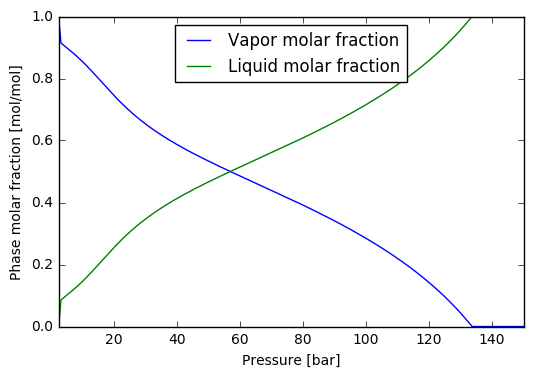

In [29]:
temperature = 350.0 # [K]
pressure = np.linspace(2.5, 150.0, num=200) * 1.0e5 # [Pa]

# Create EoS object and set properties
props = input_properties_case_whitson_problem_18_PR()
(_, _, global_molar_fractions, 
critical_pressure, critical_temperature, acentric_factor,
molar_mass, omega_a, omega_b, binary_interaction) = props
eos_pr = PengRobinsonEos(critical_pressure, critical_temperature, acentric_factor, 
                      omega_a, omega_b, binary_interaction)

result = calculate_molar_fraction_curve(eos, pressure, temperature, global_molar_fractions)


pressure_bar = pressure / 1.0e5
plt.plot(pressure_bar, result, label='Vapor molar fraction')
plt.plot(pressure_bar, 1.0-result, label='Liquid molar fraction')
plt.xlabel('Pressure [bar]')
plt.ylabel('Phase molar fraction [mol/mol]')
plt.legend(loc='upper center')
plt.axis([np.min(pressure_bar), np.max(pressure_bar), 0.0, 1.0])
plt.show()

# Comparisons of Different Equation of State

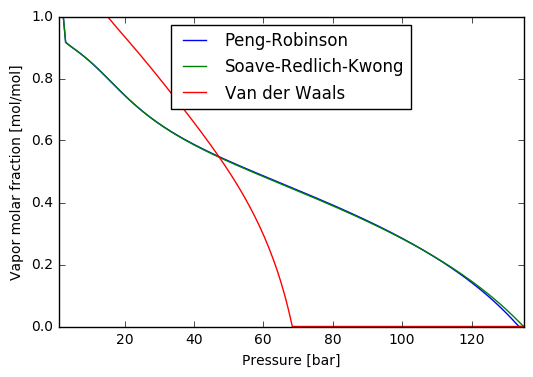

In [30]:
# PENG-ROBINSON
props = input_properties_case_whitson_problem_18_PR()
(_, _, global_molar_fractions, 
critical_pressure, critical_temperature, acentric_factor,
molar_mass, omega_a, omega_b, binary_interaction) = props
eos_pr = PengRobinsonEos(critical_pressure, critical_temperature, acentric_factor, 
                      omega_a, omega_b, binary_interaction)
# SOAVE-REDLICH-KWONG
props = input_properties_case_whitson_problem_18_SRK()
(_, _, global_molar_fractions, 
critical_pressure, critical_temperature, acentric_factor,
molar_mass, omega_a, omega_b, binary_interaction) = props
eos_srk = SoaveRedlichKwongEos(critical_pressure, critical_temperature, acentric_factor, 
                      omega_a, omega_b, binary_interaction)
# VAN DER WAALS
props = input_properties_case_whitson_problem_18_VDW()
(_, _, global_molar_fractions, 
critical_pressure, critical_temperature, acentric_factor,
molar_mass, omega_a, omega_b, binary_interaction) = props
eos_vdw = VanDerWaalsEos(critical_pressure, critical_temperature, acentric_factor, 
                      omega_a, omega_b, binary_interaction)

temperature = 350.0 # [K]
pressure = np.linspace(1, 135.0, num=200) * 1.0e5 # [Pa]
result_pr = calculate_molar_fraction_curve(eos_pr, pressure, temperature, global_molar_fractions)
result_srk = calculate_molar_fraction_curve(eos_srk, pressure, temperature, global_molar_fractions)
result_vdw = calculate_molar_fraction_curve(eos_vdw, pressure, temperature, global_molar_fractions)

pressure_bar = pressure / 1.0e5
plt.plot(pressure_bar, result_pr, label='Peng-Robinson')
plt.plot(pressure_bar, result_srk, label='Soave-Redlich-Kwong')
plt.plot(pressure_bar, result_vdw, label='Van der Waals')
plt.xlabel('Pressure [bar]')
plt.ylabel('Vapor molar fraction [mol/mol]')
plt.legend(loc='upper center')
plt.axis([np.min(pressure_bar), np.max(pressure_bar), 0.0, 1.0])
plt.show()

# Retrograde Condensation

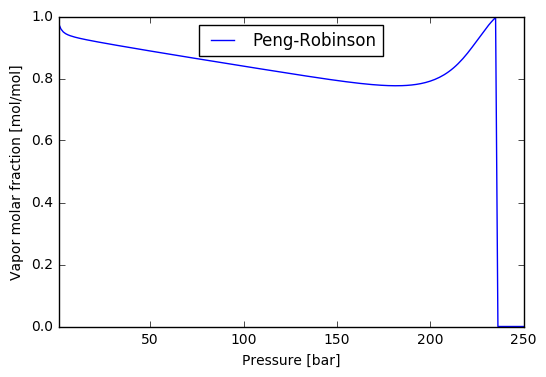

In [31]:
# PENG-ROBINSON
props = input_properties_case_7_psudocomponents()
(_, _, global_molar_fractions, 
critical_pressure, critical_temperature, acentric_factor,
molar_mass, omega_a, omega_b, binary_interaction) = props
eos_pr = PengRobinsonEos(critical_pressure, critical_temperature, acentric_factor, 
                      omega_a, omega_b, binary_interaction)

temperature = 350.0 # [K]
pressure = np.linspace(1.0, 250.0, num=200) * 1.0e5 # [Pa]
result_pr = calculate_molar_fraction_curve(eos_pr, pressure, temperature, global_molar_fractions)

pressure_bar = pressure / 1.0e5
plt.plot(pressure_bar, result_pr, label='Peng-Robinson')

plt.xlabel('Pressure [bar]')
plt.ylabel('Vapor molar fraction [mol/mol]')
plt.legend(loc='upper center')
plt.axis([np.min(pressure_bar), np.max(pressure_bar), 0.0, 1.0])
plt.show()

# Near critical point

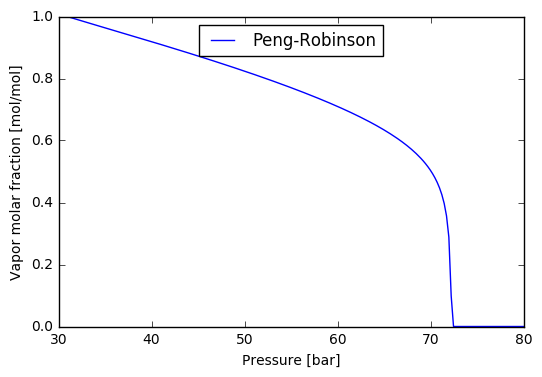

In [33]:
# PENG-ROBINSON
props = input_properties_case_dissertation_PR()
(_, _, global_molar_fractions, 
critical_pressure, critical_temperature, acentric_factor,
molar_mass, omega_a, omega_b, binary_interaction) = props
eos_pr = PengRobinsonEos(critical_pressure, critical_temperature, acentric_factor, 
                      omega_a, omega_b, binary_interaction)

#temperature = 366.5 # [K] Easy ss flash converges
temperature = 408.0 # [K] Hard, number of iter reached!
pressure = np.linspace(30.0, 80.0, num=200) * 1.0e5 # [Pa]
result_pr = calculate_molar_fraction_curve(
    eos_pr, pressure,
    temperature, global_molar_fractions, print_statistics=False
)

pressure_bar = pressure / 1.0e5
plt.plot(pressure_bar, result_pr, label='Peng-Robinson')

plt.xlabel('Pressure [bar]')
plt.ylabel('Vapor molar fraction [mol/mol]')
plt.legend(loc='upper center')
plt.axis([np.min(pressure_bar), np.max(pressure_bar), 0.0, 1.0])
plt.show()